In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import cv2
import os
import matplotlib.pyplot as plt

In [2]:
# Definiera sökvägen till datasetet
path = "./data/age_gender/UTKFace"
files = os.listdir(path)

images = []
ages = []
genders = []

# Ladda och förbered bilder samt etiketter
for file in files:
    image = cv2.imread(os.path.join(path, file), cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (64, 64))
    image = image.reshape((64, 64, 1))
    images.append(image)
    
    age, gender = int(file.split('_')[0]), int(file.split('_')[1])
    ages.append(age)
    genders.append(gender)

# Konvertera till numpy-arrayer
images = np.array(images)
ages = np.array(ages)
genders = np.array(genders)

In [3]:
# Dela data i tränings- och valideringsuppsättningar
X_train, X_val, y_age_train, y_age_val, y_gender_train, y_gender_val = train_test_split(
    images, ages, genders, test_size=0.2, random_state=42
)

# Kombinera ålder och kön i en enda numpy-array
y_train_combined = np.column_stack((y_age_train, y_gender_train))
y_val_combined = np.column_stack((y_age_val, y_gender_val))

print(f"Form på y_train_combined: {y_train_combined.shape}")

Form på y_train_combined: (18966, 2)


In [4]:
# Dataaugmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [5]:
# Anpassad generator för att mata in data i modellen
def custom_generator(data, labels, batch_size):
    while True:
        indices = np.arange(len(data))
        np.random.shuffle(indices)
        for i in range(0, len(data), batch_size):
            batch_indices = indices[i:i+batch_size]
            batch_data = data[batch_indices]
            batch_labels = labels[batch_indices]
            yield batch_data, {'age_output': batch_labels[:, 0], 'gender_output': batch_labels[:, 1]}

batch_size = 32
train_generator = custom_generator(X_train, y_train_combined, batch_size=batch_size)
validation_generator = custom_generator(X_val, y_val_combined, batch_size=batch_size)

steps_per_epoch = len(X_train) // batch_size
validation_steps = len(X_val) // batch_size

print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")

Steps per epoch: 592
Validation steps: 148


In [6]:
# Bygg en modell med separata utgångar för ålder och kön
input_layer = Input(shape=(64, 64, 1))

x = Conv2D(32, (3, 3), activation='relu')(input_layer)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.5)(x)
x = Flatten()(x)

age_output = Dense(1, name='age_output')(x)
gender_output = Dense(1, activation='sigmoid', name='gender_output')(x)

model = Model(inputs=input_layer, outputs=[age_output, gender_output])

# Kompilera modellen
model.compile(optimizer='adam', 
              loss={'age_output': 'mse', 'gender_output': 'binary_crossentropy'}, 
              metrics={'age_output': 'mae', 'gender_output': 'accuracy'})

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 62, 62,    │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 31, 31,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 31, 31,    │          0 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 30752)     │          0 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ age_output (Dense)  │ (None, 1)         │     30,753 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gender_output       │ (None, 1)         │     30,753 │ flatten[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 61,826 (241.51 KB)

 Trainable params: 61,826 (241.51 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Träna modellen
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    verbose=1
)

Epoch 1/50
592/592 ━━━━━━━━━━━━━━━━━━━━ 15s 21ms/step - age_output_mae: 52.1309 - gender_output_accuracy: 0.6581 - loss: 10084.5381 - val_age_output_mae: 11.3025 - val_gender_output_accuracy: 0.7977 - val_loss: 212.8902
Epoch 2/50
592/592 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - age_output_mae: 12.8836 - gender_output_accuracy: 0.8144 - loss: 274.2106 - val_age_output_mae: 10.5955 - val_gender_output_accuracy: 0.8535 - val_loss: 186.0450
Epoch 3/50
592/592 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - age_output_mae: 11.3433 - gender_output_accuracy: 0.8324 - loss: 217.6834 - val_age_output_mae: 10.1195 - val_gender_output_accuracy: 0.8527 - val_loss: 179.0061
Epoch 4/50
592/592 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - age_output_mae: 10.7237 - gender_output_accuracy: 0.8377 - loss: 195.7193 - val_age_output_mae: 12.0510 - val_gender_output_accuracy: 0.8516 - val_loss: 249.6447
Epoch 5/50
592/592 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - age_output_mae: 10.7757 - gender_output_accuracy: 0.8426 - loss: 195.4

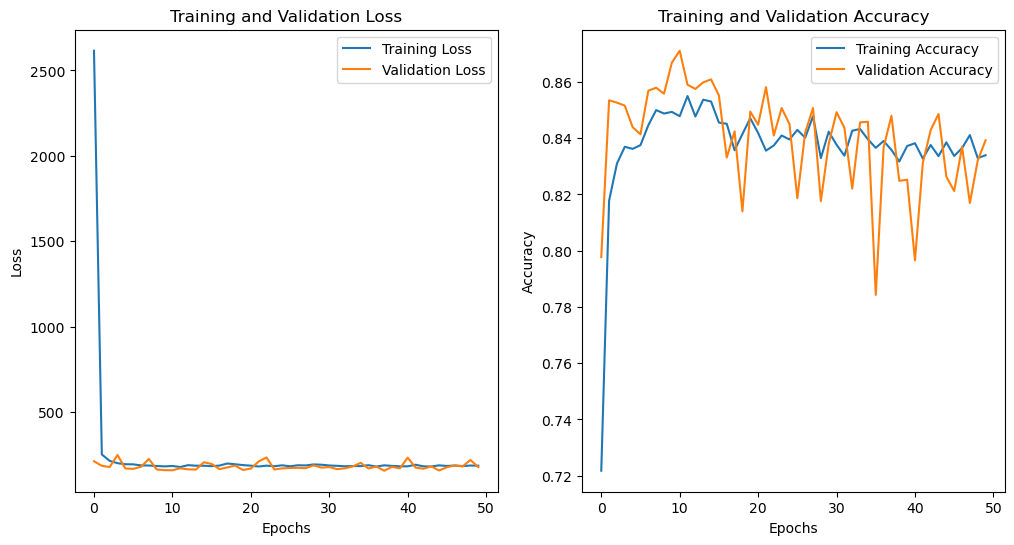

In [8]:
# Visualisera tränings- och valideringsförlust samt noggrannhet
plt.figure(figsize=(12, 6))

# Förlust
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Noggrannhet
plt.subplot(1, 2, 2)
plt.plot(history.history['gender_output_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_gender_output_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [9]:
# Utvärdera modellen på träningsdata
train_loss, train_age_mae, train_gender_accuracy = model.evaluate(train_generator, steps=steps_per_epoch)
print(f"Träning - Förlust: {train_loss}, Ålder MAE: {train_age_mae}, Kön Noggrannhet: {train_gender_accuracy}")

# Utvärdera modellen på valideringsdata
val_loss, val_age_mae, val_gender_accuracy = model.evaluate(validation_generator, steps=validation_steps)
print(f"Validering - Förlust: {val_loss}, Ålder MAE: {val_age_mae}, Kön Noggrannhet: {val_gender_accuracy}")

592/592 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - age_output_mae: 9.1966 - gender_output_accuracy: 0.9050 - loss: 138.5404
Träning - Förlust: 137.97247314453125, Ålder MAE: 9.180893898010254, Kön Noggrannhet: 0.9079433679580688
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - age_output_mae: 10.1723 - gender_output_accuracy: 0.8394 - loss: 171.5226
Validering - Förlust: 173.3543243408203, Ålder MAE: 10.232426643371582, Kön Noggrannhet: 0.8418259024620056


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


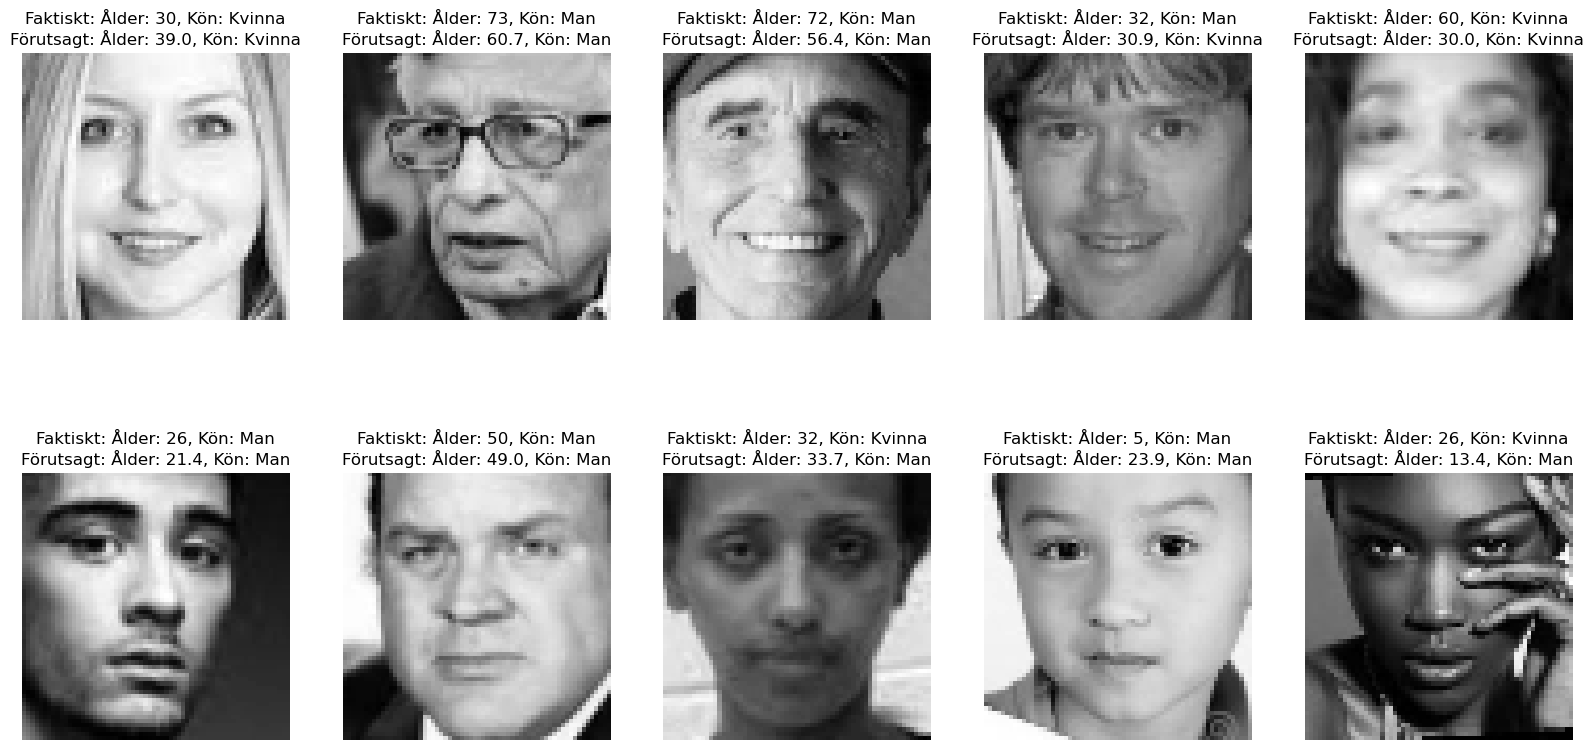

In [11]:
# Gör förutsägelser på en batch av valideringsdata
val_data_batch, val_label_batch = next(validation_generator)
age_predictions, gender_predictions = model.predict(val_data_batch)

# Tolkning av könsprediktioner
gender_predictions_interpreted = np.where(gender_predictions > 0.5, 1, 0)  # 1 = Kvinna, 0 = Man

# Visualisera de första 10 bilderna med förutsägelser
plt.figure(figsize=(20, 10))
for i in range(min(10, len(val_data_batch))):  # Se till att inte gå utanför batchens storlek
    plt.subplot(2, 5, i+1)
    plt.imshow(val_data_batch[i].reshape(64, 64), cmap='gray')

    # Faktiska värden
    actual_age = val_label_batch['age_output'][i]  # Hämta åldern
    actual_gender = 'Kvinna' if val_label_batch['gender_output'][i] == 1 else 'Man'  # Hämta könet


    # Förutsagda värden
    predicted_age = age_predictions[i][0]
    predicted_gender = 'Kvinna' if gender_predictions_interpreted[i] == 1 else 'Man'

    plt.title(f"Faktiskt: Ålder: {actual_age}, Kön: {actual_gender}\n"
              f"Förutsagt: Ålder: {predicted_age:.1f}, Kön: {predicted_gender}")
    plt.axis('off')
plt.show()

In [13]:
# Spara den tränade modellen
model.save('age_gender_detection_model.keras')

In [43]:
# Ladda den sparade modellen
model = tf.keras.models.load_model('age_gender_detection_model.keras')

# Starta webbkameran
cap = cv2.VideoCapture(0)

# För att jämna ut prediktionerna, använd en lista för att lagra tidigare prediktioner
predicted_ages = []
window_size = 5  # Ändra detta för att justera hur många tidigare prediktioner att genomsnittliga

while True:
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    for (x, y, w, h) in faces:
        face = frame[y:y+h, x:x+w]
        face_rgb = cv2.resize(face, (64, 64))
        face_rgb = cv2.cvtColor(face_rgb, cv2.COLOR_BGR2GRAY)  # Konvertera till gråskala
        face_rgb = np.expand_dims(face_rgb, axis=-1)  # Lägg till kanal-dimensionen igen
        face_rgb = np.expand_dims(face_rgb, axis=0)  # Lägg till batch-dimension

        # Gör förutsägelser med den laddade modellen
        predictions = model.predict(face_rgb)
        age_prediction = predictions[0][0][0]  # Ta första elementet för ålder
        gender_prediction = predictions[1][0][0]  # Ta första elementet för kön

        # Lägg till den senaste åldersprediktionen till listan
        predicted_ages.append(age_prediction)

        # Jämna ut åldersprediktionen genom att använda ett glidande medelvärde
        if len(predicted_ages) > window_size:
            predicted_ages.pop(0)

        avg_age = np.mean(predicted_ages)

        # Tolkning av kön
        gender_label = 'Man' if gender_prediction < 0.5 else 'Kvinna'

        # Visa resultaten på skärmen
        cv2.putText(frame, f"Age: {avg_age:.1f}", (x, y-40), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 255, 255), 2)
        cv2.putText(frame, f"Gender: {gender_label}", (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 255, 255), 2)
        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 255, 255), 2)

        # Skriv ut prediktionerna
        print(f"Prediktion: Age: {avg_age:.1f}, Gender: {gender_label}")

    cv2.imshow('Age and Gender Detector', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Prediktion: Age: 31.3, Gender: Man
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Prediktion: Age: 37.2, Gender: Kvinna
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Prediktion: Age: 38.1, Gender: Man
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Prediktion: Age: 39.2, Gender: Kvinna
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Prediktion: Age: 38.6, Gender: Kvinna
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Prediktion: Age: 40.0, Gender: Kvinna
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Prediktion: Age: 39.1, Gender: Kvinna
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediktion: Age: 37.8, Gender: Kvinna
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Prediktion: Age: 37.1, Gender: Kvinna
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Prediktion: Age: 37.3, Gender: Kvinna
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Prediktion: Age: 37.1, Gender: Kvinna
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Prediktion: Age: 36.4, Gender: Kvinna
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Prediktion: Age: 37.0, Gender: Kvinna
1/1 ━━━━━━━━━━━━━━